## Classifying human vs GPT generated articles and determining most important factors

Neccessary imports

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import shap
from sklearn.preprocessing import OneHotEncoder

Reading in, dropping columns and examining the data

In [29]:
df = pd.read_csv("phase_3_df.csv")

df.drop(columns=["Unnamed: 0","url"], inplace=True)
df.head()

,title,content,topic,gpt_text,category,token_count_ai,token_count,sent_count,sent_count_ai,tokens_per_sentence,tokens_per_sentence_ai,fk_grade,gunning_fog,fk_grade_ai,gunning_fog_ai,ttr_human,ttr_gpt,orgs_gpt,locs_gpt,persons_gpt,orgs_human,locs_human,persons_human,contractions_human,contractions_gpt,first_pronouns_human,third_pronouns_human,first_pronouns_gpt,third_pronouns_gpt,passive_human,passive_gpt,noun_pct_human,verb_pct_human,adj_pct_human,adv_pct_human,noun_pct_gpt,verb_pct_gpt,adj_pct_gpt,adv_pct_gpt,title_length,sentiment_human,subjectivity_human,sentiment_gpt,subjectivity_gpt,bias_terms_human,bias_terms_gpt
0,Sussex : Artificial intelligence spotted my ...,Artificial intelligence 'spotted' my breast ca...,artificial intelligence,In a groundbreaking development that underscor...,Artificial Intelligence,569,477,18,24,26.500000,23.708333,10.9,12.77,13.8,15.55,0.637838,0.590361,0.000000,8.787346,1.757469,10.482180,10.482180,4.192872,4.192872,7.029877,20.964361,12.578616,10.544815,8.787346,10.482180,10.544815,0.251732,0.193995,0.090069,0.036952,0.293073,0.145648,0.097691,0.028419,8,0.091488,0.469964,0.086796,0.472062,0.000000,0.000000
1,TSMC reportedly halts advanced chip shipments ...,After a chip manufactured by Taiwan Semiconduc...,artificial intelligence,In a move that could significantly impact the ...,Artificial Intelligence,492,163,5,18,32.600000,27.333333,13.4,15.35,16.9,17.39,0.750000,0.610169,18.292683,14.227642,0.000000,67.484663,12.269939,0.000000,0.000000,12.195122,0.000000,0.000000,0.000000,6.097561,12.269939,4.065041,0.326667,0.213333,0.066667,0.026667,0.317391,0.113043,0.123913,0.028261,9,0.040625,0.490625,0.059704,0.458034,6.134969,2.032520
2,The Wall Street Journal is testing AI article ...,The Wall Street Journal is experimenting with ...,artificial intelligence,"The Wall Street Journal, a leading name in glo...",Artificial Intelligence,549,309,12,19,25.750000,28.894737,12.0,13.14,16.8,17.98,0.650794,0.555556,12.750455,0.000000,0.000000,38.834951,0.000000,9.708738,0.000000,1.821494,19.417476,0.000000,0.000000,3.642987,3.236246,3.642987,0.364865,0.158784,0.050676,0.027027,0.317490,0.155894,0.095057,0.020913,9,0.049026,0.650325,0.077776,0.506301,0.000000,0.000000
3,a16z VC Martin Casado explains why so many AI ...,The problem with most attempts at regulating A...,AI regulation,In a compelling discussion at a recent tech co...,Artificial Intelligence,563,912,35,23,26.057143,24.478261,10.9,11.77,14.8,17.01,0.590054,0.610169,1.776199,0.000000,19.538188,18.640351,4.385965,15.350877,0.000000,7.104796,7.675439,17.543860,3.552398,23.090586,8.771930,5.328597,0.283146,0.177528,0.083146,0.042697,0.261993,0.156827,0.092251,0.038745,13,0.078333,0.407553,0.106364,0.505510,0.000000,0.000000
4,Top House committee subpoenas Biden admin for ...,FIRST ON FOX: The House Homeland Security Comm...,machine learning,In a significant move reflecting ongoing tensi...,Artificial Intelligence,565,1064,27,20,39.407407,28.250000,15.5,15.39,18.8,18.54,0.550117,0.587045,7.079646,5.309735,7.079646,32.894737,5.639098,14.097744,0.000000,14.159292,0.939850,4.699248,5.309735,3.539823,1.879699,12.389381,0.346035,0.140062,0.072091,0.030896,0.303411,0.161580,0.087971,0.021544,16,0.121371,0.407907,0.016414,0.495202,3.759398,1.769912


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3295 entries, 0 to 3294
Data columns (total 46 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   title                   3295 non-null   object 
 1   content                 3295 non-null   object 
 2   topic                   3295 non-null   object 
 3   gpt_text                3295 non-null   object 
 4   category                3295 non-null   object 
 5   token_count_ai          3295 non-null   int64  
 6   token_count             3295 non-null   int64  
 7   sent_count              3295 non-null   int64  
 8   sent_count_ai           3295 non-null   int64  
 9   tokens_per_sentence     3295 non-null   float64
 10  tokens_per_sentence_ai  3295 non-null   float64
 11  fk_grade                3295 non-null   float64
 12  gunning_fog             3295 non-null   float64
 13  fk_grade_ai             3295 non-null   float64
 14  gunning_fog_ai          3295 non-null   

Breaking out the data so that each human and gpt version of the same article are in separate rows. This also halves the number of columns needed.

In [20]:
gpt_cols = {
    # 'token_count_ai': 'token_count',
    # 'sent_count_ai': 'sent_count',
    # 'tokens_per_sentence_ai': 'tokens_per_sentence',
    'fk_grade_ai': 'fk_grade',
    'gunning_fog_ai': 'gunning_fog',
    'ttr_gpt': 'ttr',
    'orgs_gpt': 'orgs', 'locs_gpt': 'locs', 'persons_gpt': 'persons',
    'contractions_gpt': 'contractions',
    'first_pronouns_gpt': 'first_pronouns',
    'third_pronouns_gpt': 'third_pronouns',
    'passive_gpt': 'passive',
    'noun_pct_gpt': 'noun_pct', 'verb_pct_gpt': 'verb_pct',
    'adj_pct_gpt': 'adj_pct', 'adv_pct_gpt': 'adv_pct',
    'sentiment_gpt': 'sentiment', 'subjectivity_gpt': 'subjectivity',
    'bias_terms_gpt': 'bias_terms'
}

human_cols = {
    # 'token_count': 'token_count',
    # 'sent_count': 'sent_count',
    # 'tokens_per_sentence': 'tokens_per_sentence',
    'fk_grade': 'fk_grade',
    'gunning_fog': 'gunning_fog',
    'ttr_human': 'ttr',
    'orgs_human': 'orgs', 'locs_human': 'locs', 'persons_human': 'persons',
    'contractions_human': 'contractions',
    'first_pronouns_human': 'first_pronouns',
    'third_pronouns_human': 'third_pronouns',
    'passive_human': 'passive',
    'noun_pct_human': 'noun_pct', 'verb_pct_human': 'verb_pct',
    'adj_pct_human': 'adj_pct', 'adv_pct_human': 'adv_pct',
    'sentiment_human': 'sentiment', 'subjectivity_human': 'subjectivity',
    'bias_terms_human': 'bias_terms'
}

# Build GPT feature rows
gpt_df = df[[
    'title', 'category', 'topic', 'gpt_text'
] + list(gpt_cols.keys())].copy()

gpt_df = gpt_df.rename(columns=gpt_cols)
gpt_df['text'] = gpt_df.pop('gpt_text')
gpt_df['source'] = 1

# Build Human feature rows
human_df = df[[
    'title', 'category', 'topic', 'content'
] + list(human_cols.keys())].copy()

human_df = human_df.rename(columns=human_cols)
human_df['text'] = human_df.pop('content')
human_df['source'] = 0

# Columns are now aligned and consistent
combined_df = pd.concat([gpt_df, human_df], ignore_index=True)
combined_df.head()

,title,category,topic,fk_grade,gunning_fog,ttr,orgs,locs,persons,contractions,first_pronouns,third_pronouns,passive,noun_pct,verb_pct,adj_pct,adv_pct,sentiment,subjectivity,bias_terms,text,source
0,Sussex : Artificial intelligence spotted my ...,Artificial Intelligence,artificial intelligence,13.8,15.55,0.590361,0.000000,8.787346,1.757469,7.029877,10.544815,8.787346,10.544815,0.293073,0.145648,0.097691,0.028419,0.086796,0.472062,0.000000,In a groundbreaking development that underscor...,1
1,TSMC reportedly halts advanced chip shipments ...,Artificial Intelligence,artificial intelligence,16.9,17.39,0.610169,18.292683,14.227642,0.000000,12.195122,0.000000,6.097561,4.065041,0.317391,0.113043,0.123913,0.028261,0.059704,0.458034,2.032520,In a move that could significantly impact the ...,1
2,The Wall Street Journal is testing AI article ...,Artificial Intelligence,artificial intelligence,16.8,17.98,0.555556,12.750455,0.000000,0.000000,1.821494,0.000000,3.642987,3.642987,0.317490,0.155894,0.095057,0.020913,0.077776,0.506301,0.000000,"The Wall Street Journal, a leading name in glo...",1
3,a16z VC Martin Casado explains why so many AI ...,Artificial Intelligence,AI regulation,14.8,17.01,0.610169,1.776199,0.000000,19.538188,7.104796,3.552398,23.090586,5.328597,0.261993,0.156827,0.092251,0.038745,0.106364,0.505510,0.000000,In a compelling discussion at a recent tech co...,1
4,Top House committee subpoenas Biden admin for ...,Artificial Intelligence,machine learning,18.8,18.54,0.587045,7.079646,5.309735,7.079646,14.159292,5.309735,3.539823,12.389381,0.303411,0.161580,0.087971,0.021544,0.016414,0.495202,1.769912,In a significant move reflecting ongoing tensi...,1


I commented out the features that relate purely to tokens or sentence counts. From the prior analysis, these columns show distinct differences since human articles are much longer on average. These features would be heavily biasing the model and I wouldn't accurately be able to say which of the descriptive stylistic features differentiate human vs gpt writing.

Creating dummy variables for the categorical data

In [30]:
# Select categorical columns
categoricals = ['category', 'topic']

# One hot encoding
df_encoded = pd.get_dummies(combined_df, columns=categoricals, drop_first=True)

# Dropping the target feature and non informative columns
X = df_encoded.drop(columns=['title', 'text', 'source'])  
# Creating target variable
y = df_encoded['source']

Running a simple Random Forest Model

In [ ]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Train model
rf = RandomForestClassifier(random_state=42)

rf.fit(X_train, y_train)
y_pred = rf.predict(X)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3295
           1       0.99      1.00      0.99      3295

    accuracy                           0.99      6590
   macro avg       0.99      0.99      0.99      6590
weighted avg       0.99      0.99      0.99      6590



Converting all the boolean columns to numerics for SHAP value creation

In [46]:
X_train = X_train.astype({col: 'int' for col in X_train.select_dtypes('bool').columns})
X_test = X_test.astype({col: 'int' for col in X_test.select_dtypes('bool').columns})

Generating SHAP values to see which features are most deterministic

 97%|=================== | 2567/2636 [00:41<00:01]       

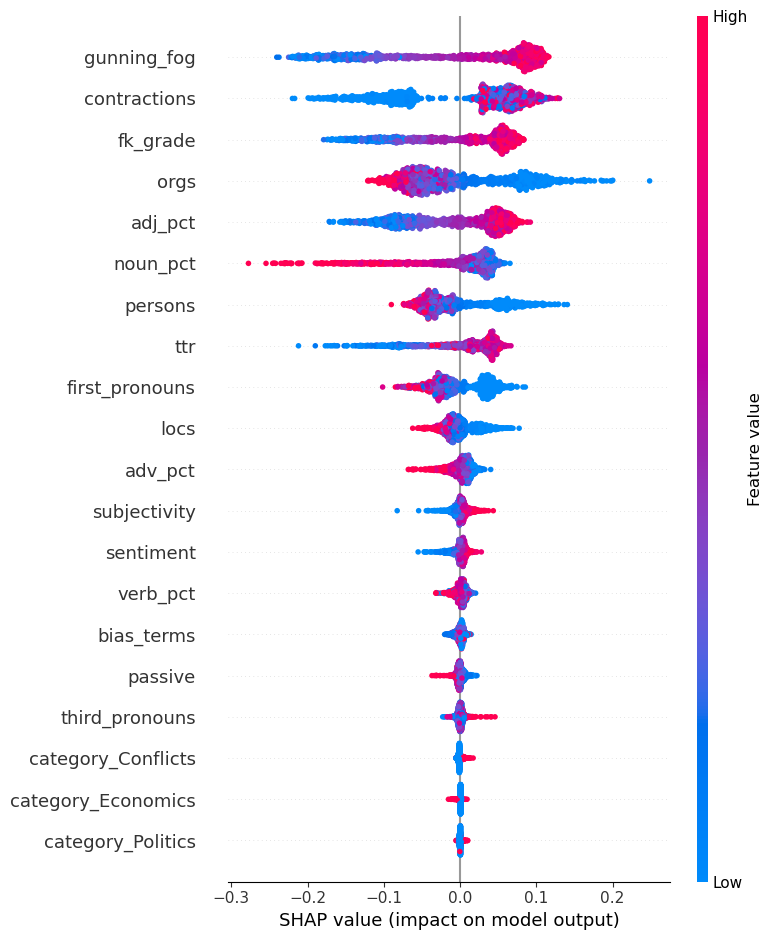

In [49]:
explainer = shap.Explainer(rf, X_train)

shap_values = explainer(X_test, check_additivity=False)

# Generating the plot
shap.summary_plot(shap_values[..., 1], X_test)

Tails to the right mean it's more impactful on determining if the article was gpt generated. To the left is indicative of the human articles.

Using the Random Forest feature importance scores for a second interpretation

In [53]:
importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)

print(importances.head(10))

           feature  importance
1      gunning_fog    0.149674
0         fk_grade    0.147603
12         adj_pct    0.135330
6     contractions    0.094831
3             orgs    0.094526
10        noun_pct    0.068382
7   first_pronouns    0.062936
2              ttr    0.059931
5          persons    0.051730
4             locs    0.026028
